In [58]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean.cm as cm
import datetime as dt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
import pickle 
import os
from salishsea_tools import viz_tools, geo_tools
import arrow
import copy
import math
import matplotlib.dates as mdates
#import NorthNut as nn
from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [59]:
# Constant and data rang
syear = 2018
eyear = 2018
smonth = 1
emonth = 3
startdate = arrow.get(syear, smonth, 1)
enddate = arrow.get(eyear, emonth, 5)
print (startdate, enddate)

2018-01-01T00:00:00+00:00 2018-03-05T00:00:00+00:00


In [60]:
mesh = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc')
bathy = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202310b.nc')
thalweg_SI = '/ocean/atall/MOAD/analysis-abdoul/thalweg_files/SaanichInlet_thalweg.txt' 
thalweg_HC = '/ocean/atall/MOAD/analysis-abdoul/thalweg_files/HoodCanal_thalweg.txt' 
thalweg_SoG = '/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
thalweg_ptsSI = np.loadtxt(thalweg_SI, delimiter=' ', dtype=int)
thalweg_ptsHC = np.loadtxt(thalweg_HC, delimiter=' ', dtype=int)
thalweg_ptsSoG = np.loadtxt(thalweg_SoG, delimiter=' ', dtype=int)
umask = mesh.variables['umask'][0,...]
vmask = mesh.variables['vmask'][0,...]
tmask = mesh.variables['tmask'][0,...]
depth = mesh.variables['gdept_0'][:]


In [61]:
df_biol = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/oxygen_PONref90/SalishSea_1d_*biol_T.nc')
df_chem = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/oxygen_PONref90/SalishSea_1d_*chem_T.nc')
df_grdT = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/oxygen_PONref90/SalishSea_1d_*grid_T.nc')
df_diag = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/oxygen_PONref90/SalishSea_1d_*diag_T.nc')

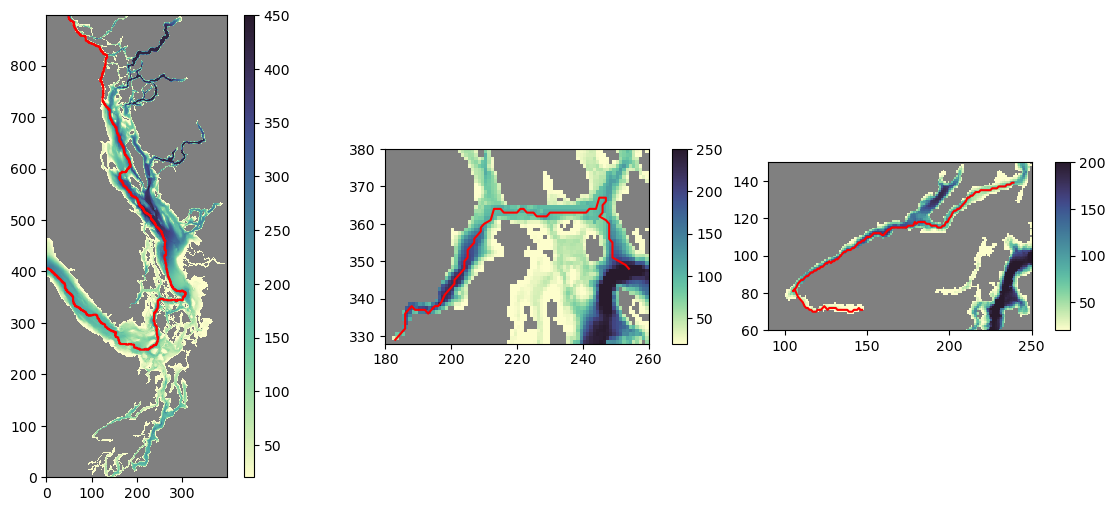

In [62]:
line, col = (1, 3)
fig, ax = plt.subplots(line, col, figsize=(14, 6))
mycmap = cm.deep
mycmap.set_bad('grey')
for ii in range(0, 0+col):
    if ii==0:
        thalweg=thalweg_ptsSoG
        vmin,vmax=(20,450)
    elif ii==1:
        thalweg=thalweg_ptsSI
        ax[ii].set_xlim([180, 260])
        ax[ii].set_ylim([328, 380])
        vmin,vmax=(20,250)
    else:
        thalweg=thalweg_ptsHC
        ax[ii].set_xlim(90,250)
        ax[ii].set_ylim(60,150)
        vmin,vmax=(20,200)

    im = ax[ii].pcolormesh(bathy.variables['Bathymetry'][:], cmap=mycmap, vmin=vmin, vmax=vmax)
    ax[ii].plot(thalweg[:,1],thalweg[:,0],color='r')
    viz_tools.set_aspect(ax[ii]);
    divider = make_axes_locatable(ax[ii])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')


Text(0.5, 0.98, 'REF90,PSRe-4,Bremin8.5')

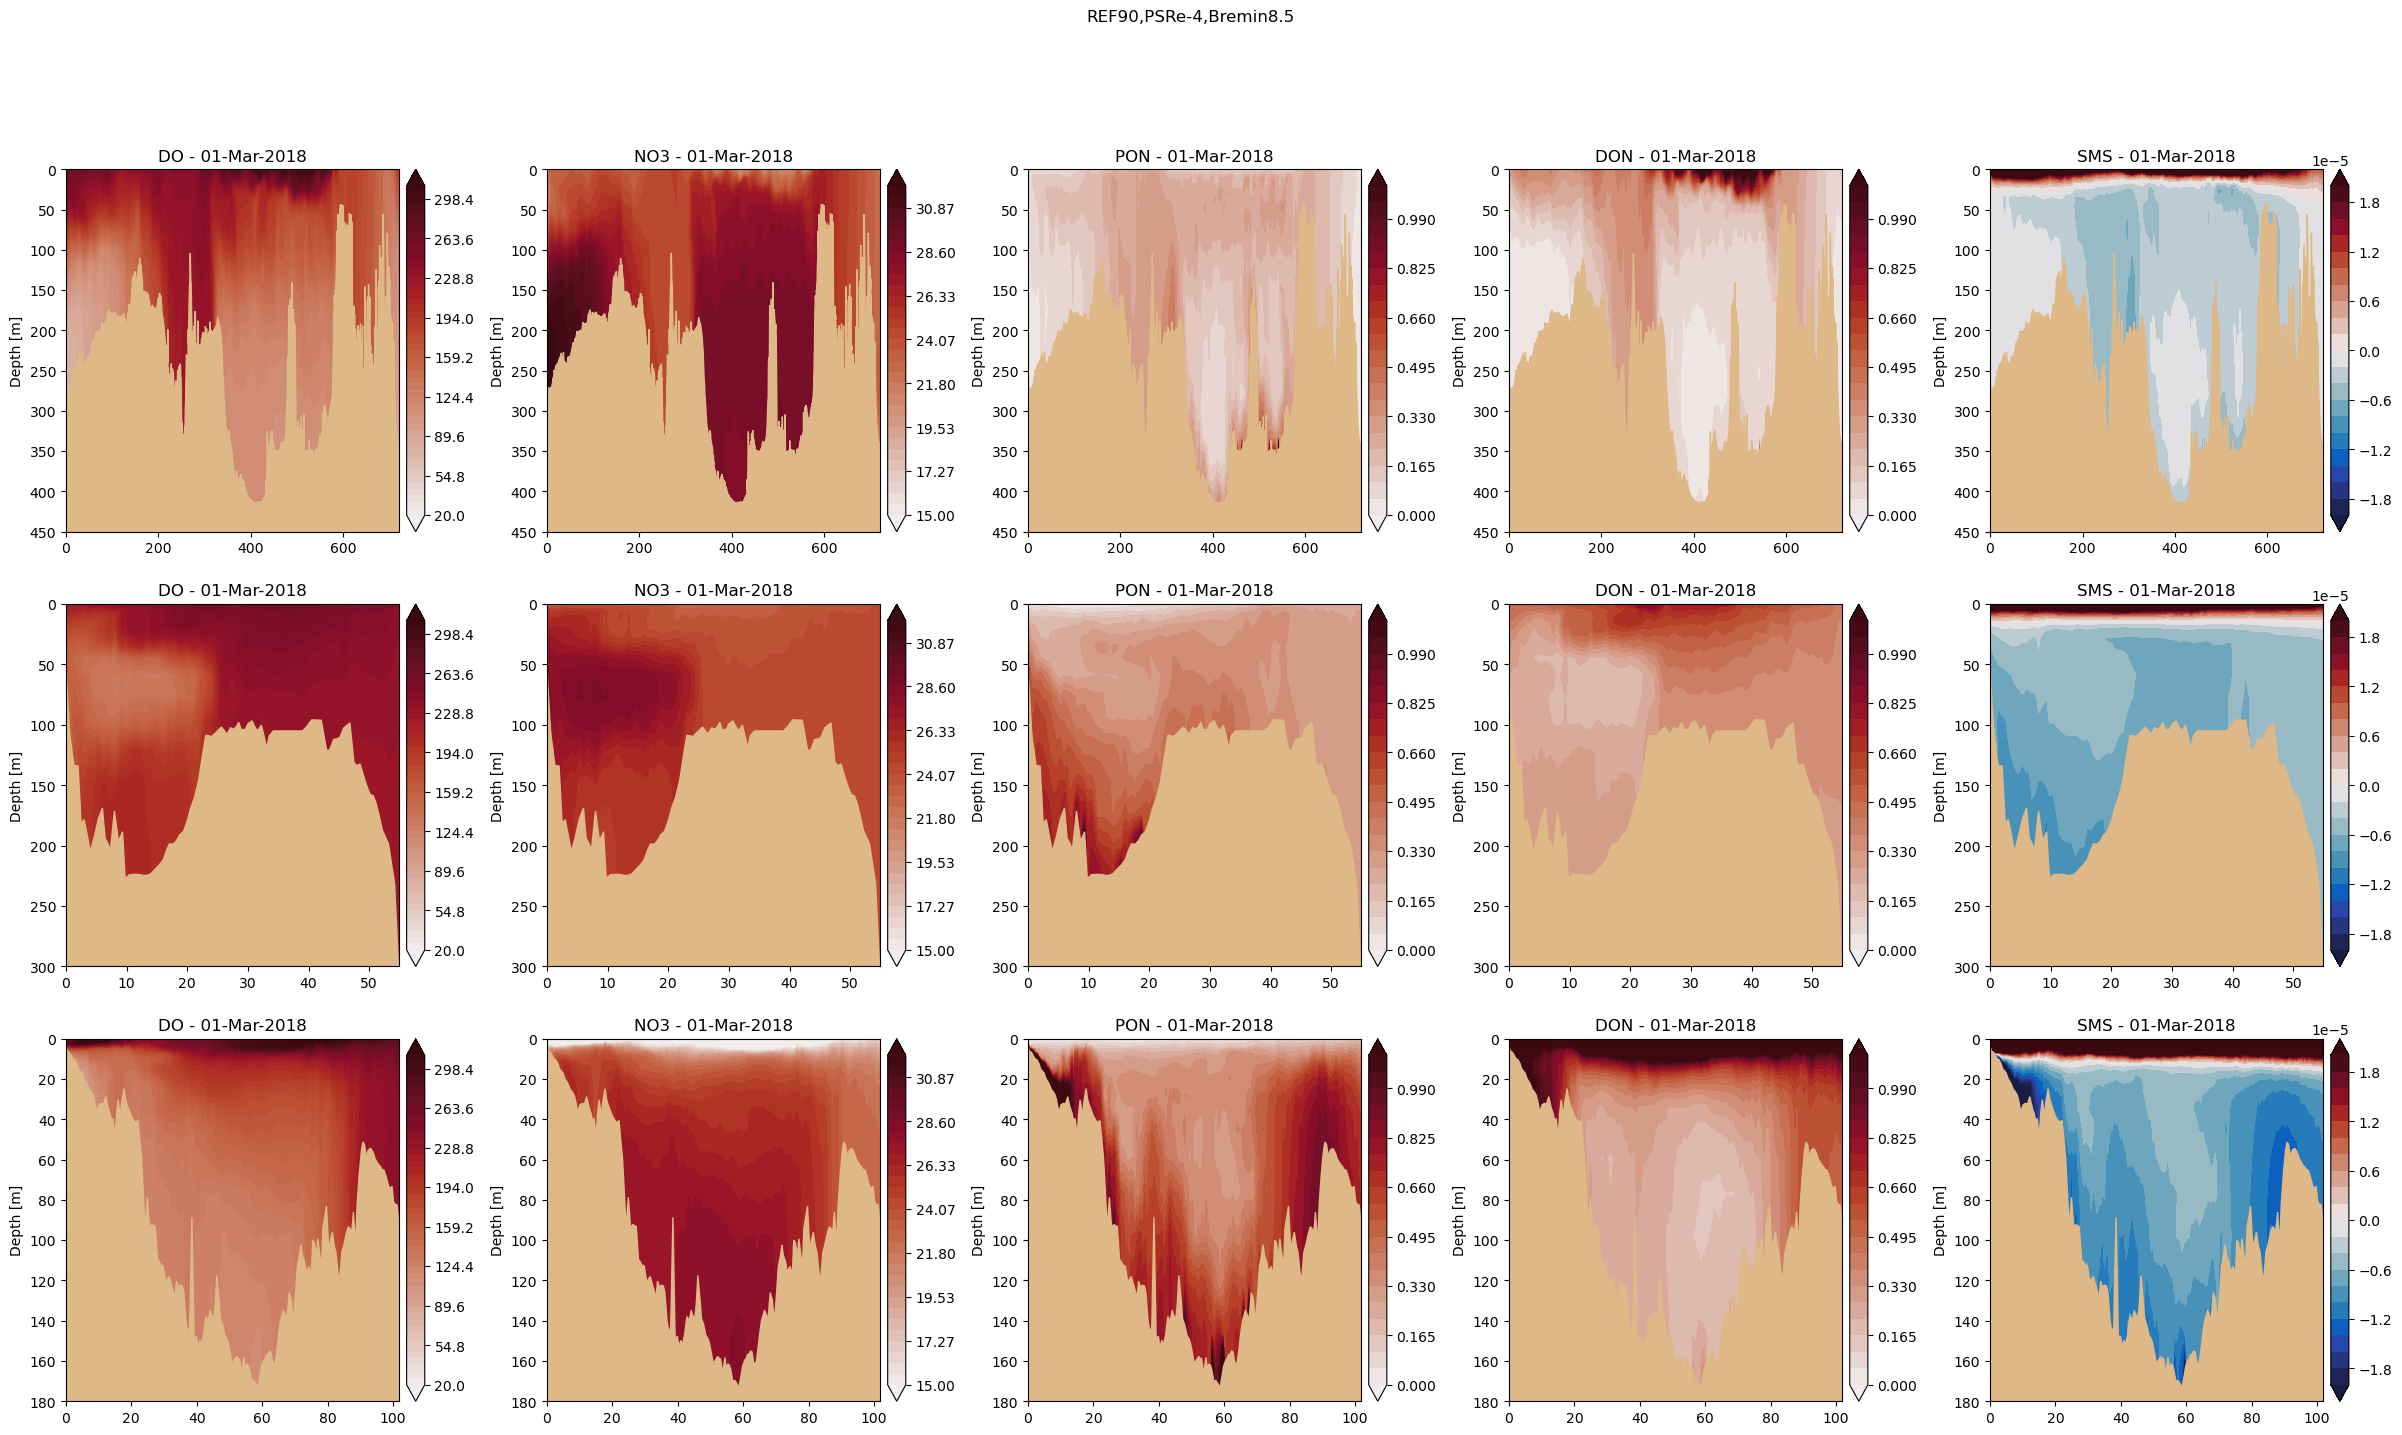

In [63]:
line, col = (3, 5)
fig, axs = plt.subplots(line, col, figsize=(30, 16))
date = list(['01-Mar-2018'])
title = list(['DO','NO3','PON','DON','SMS'])
t0=60
for ii in range(0, 0+line):
    if ii==0:
        thalweg=thalweg_ptsSoG
        depmin=450
        vmin,vmax=(20,450)
    elif ii==1:
        thalweg=thalweg_ptsSI[::-1]
        depmin=300
        vmin,vmax=(20,250)
    else:
        thalweg=thalweg_ptsHC
        depmin=180
        vmin,vmax=(20,200)
    for jj  in range(0, 0+col):
        cmap = cm.amp
        if jj==0:
            df=df_chem
            vars = df.dissolved_oxygen
            space = np.linspace(20, 310, 51)
        elif jj==1:
            df=df_biol
            vars=df.nitrate
            space = np.linspace(15, 32, 31)
        elif jj==2:
            df=df_biol
            vars=df.particulate_organic_nitrogen
            space = np.linspace(0, 1.1, 21)
        elif jj==3:
            df=df_biol
            vars=df.dissolved_organic_nitrogen
            space = np.linspace(0, 1.1, 21)
        else:
            df=df_diag
            vars= df.NPP + df.RPP + df.NITR + df.RMIN + df.RMES + df.RMIC
            space = np.linspace(-0.00002, 0.00002, 21)
            cmap = cm.balance

        dep_thal, distance, var_thal = vis.load_thalweg(
            depth[0, ...], np.array(vars[t0]), bathy['nav_lon'][:], bathy['nav_lat'][:],
                thalweg)
        var_plot = vis._fill_in_bathy(var_thal, mesh, thalweg)
        colours_var = axs[ii,jj].contourf(distance, dep_thal, var_plot, space,
                                            cmap=cmap, extend='both')
        vis._add_bathy_patch(distance, bathy['Bathymetry'][:], thalweg, axs[ii,jj], color='burlywood')
        axs[ii,jj].invert_yaxis()
        axs[ii,jj].set_ylabel('Depth [m]');
        axs[ii,jj].set_ylim([depmin, 0])
        axs[ii,jj].set_title(f'{title[jj]} - {date[t0-t0]}')
        cbar = fig.colorbar(colours_var, ax=axs[ii,jj], pad=0.02)
    
fig.suptitle('REF90,PSRe-4,Bremin8.5')

 